# 机器学习纳米学位毕业项目 -- 猫狗大战

苗沛

2018.08.15

**实验环境**

- MacBook 10.13.6
- python 3.5.4
- numpy 1.13.0
- tensorflow 1.3.0
- Keras 1.2.2
- h5py 2.7.1

## 数据预处理

从 [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) 下载训练数据到`image目录` 并解压到当前目录。

数据集的文件名是以type.num.jpg方式命名的，比如cat.0.jpg。使用 Keras 的 ImageDataGenerator 需要将不同种类的图片分在不同的文件夹中。对数据集进行预处理参考的是[杨培文的Blog](http://www.zhiding.cn/techwalker/documents/J9UpWRDfVYHE5WsOEHbyx4eM8fBcpHYEW_b72QCUihQ)创建符号链接(symbol link)的方法，这样的好处是不用复制一遍图片，占用不必要的空间。

In [1]:
import os
import shutil

os.chdir("{}/image".format(os.getcwd())) 

train_filenames = os.listdir('train')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir('img_train')
os.mkdir('img_train/cat')
os.mkdir('img_train/dog')

rmrf_mkdir('img_test')
os.symlink('../test/', 'img_test/test')

for filename in train_cat:
    os.symlink('../../train/'+filename, 'img_train/cat/'+filename)

for filename in train_dog:
    os.symlink('../../train/'+filename, 'img_train/dog/'+filename)

图像文件分类后的路径如下：

``` python 
├── test [12500 images]
├── test2
│   └── test -> ../test/
├── train [25000 images]
└── train2
    ├── cat [12500 images]
    └── dog [12500 images]

``` 

可视化数据集：

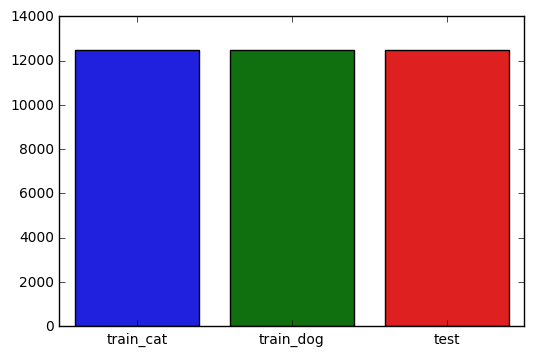

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

x = ['train_cat', 'train_dog', 'test']
y = [len(os.listdir('img_train/cat')), len(os.listdir('img_train/dog')), len(os.listdir('test'))]
ax = sns.barplot(x=x, y=y)

In [3]:
s_count = """image数据集中，猫的数量：{}，狗的数量：{}，测试集图片数量：{}""".format(len(os.listdir('img_train/cat')), len(os.listdir('img_train/dog')),len(os.listdir('test')))
s_count

'image数据集中，猫的数量：12500，狗的数量：12500，测试集图片数量：12500'

## 导出特征向量

对于这个题目来说，使用预训练的网络是最好不过的了，经过前期的测试，我们测试了 ResNet50 等不同的网络，但是排名都不高，现在看来只有一两百名的样子，所以我们需要提高我们的模型表现。那么一种有效的方法是综合各个不同的模型，从而得到不错的效果，兼听则明。如果是直接在一个巨大的网络后面加我们的全连接，那么训练10代就需要跑十次巨大的网络，而且我们的卷积层都是不可训练的，那么这个计算就是浪费的。所以我们可以将多个不同的网络输出的特征向量先保存下来，以便后续的训练，这样做的好处是我们一旦保存了特征向量，即使是在普通笔记本上也能轻松训练。

经典的CNN输入图像的尺寸，是224×224、227×227、256×256和299×299，但也可以是其他尺寸。

VGG16，VGG19和ResNet均接受224×224输入图像，而Inception V3和Xception需要299×299像素输入

In [4]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    
    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("img_train", image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory("img_test", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.nb_sample)
    test = model.predict_generator(test_generator, test_generator.nb_sample)

    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

Using TensorFlow backend.


In [ ]:
#write_gap(ResNet50, (224, 224))

In [ ]:
#write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)

In [ ]:
#write_gap(Xception, (299, 299), xception.preprocess_input)

## 载入特征向量

经过上面的代码以后，我们获得了三个特征向量文件，分别是：

- gap_ResNet50.h5
- gap_InceptionV3.h5
- gap_Xception.h5

这里需要载入这些特征向量，并且将它们合成一条特征向量，然后记得把 X 和 y 打乱，不然之后设置validation_split的时候会出问题。这里设置了 numpy 的随机数种子为2018。

In [15]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2018)

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

## 构建模型

模型的构建很简单，直接 dropout 然后分类就好了。

In [71]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

对模型进行可视化：

进入model_graphviz目录执行make，生成model.png

<img src="source/model.png">

<img src="source/nnarch1-1.png"/>

## 训练模型

模型构件好了以后，我们就可以进行训练了，这里我们设置验证集大小为 20% ，也就是说训练集是20000张图，验证集是5000张图。

In [ ]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot, plot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
hist = model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 1s - loss: 0.1209 - acc: 0.9588 - val_loss: 0.0335 - val_acc: 0.9912
Epoch 2/8
20000/20000 [==============================] - 1s - loss: 0.0299 - acc: 0.9906 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 3/8
20000/20000 [==============================] - 1s - loss: 0.0226 - acc: 0.9928 - val_loss: 0.0228 - val_acc: 0.9930
Epoch 4/8
20000/20000 [==============================] - 1s - loss: 0.0194 - acc: 0.9935 - val_loss: 0.0207 - val_acc: 0.9932
Epoch 5/8
20000/20000 [==============================] - 1s - loss: 0.0177 - acc: 0.9940 - val_loss: 0.0204 - val_acc: 0.9940
Epoch 6/8
20000/20000 [==============================] - 1s - loss: 0.0167 - acc: 0.9944 - val_loss: 0.0198 - val_acc: 0.9936
Epoch 7/8
20000/20000 [==============================] - 1s - loss: 0.0161 - acc: 0.9946 - val_loss: 0.0198 - val_acc: 0.9938
Epoch 8/8
20000/20000 [==============================] - 1s - loss: 0

In [18]:
model.save('model.h5')

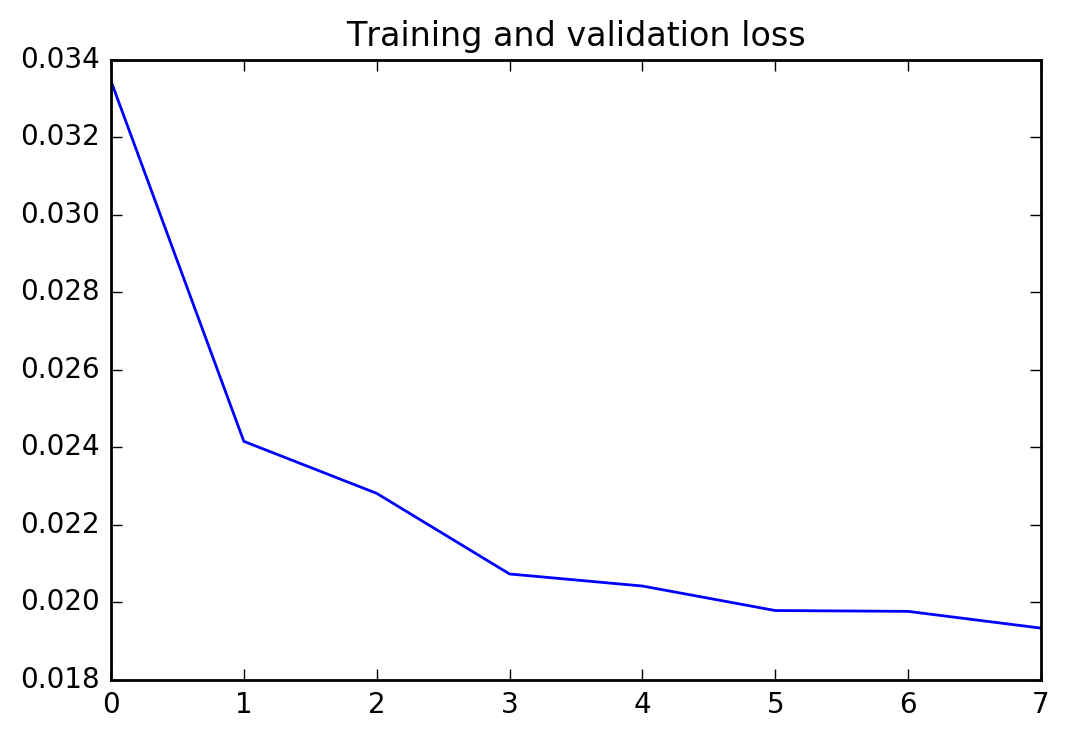

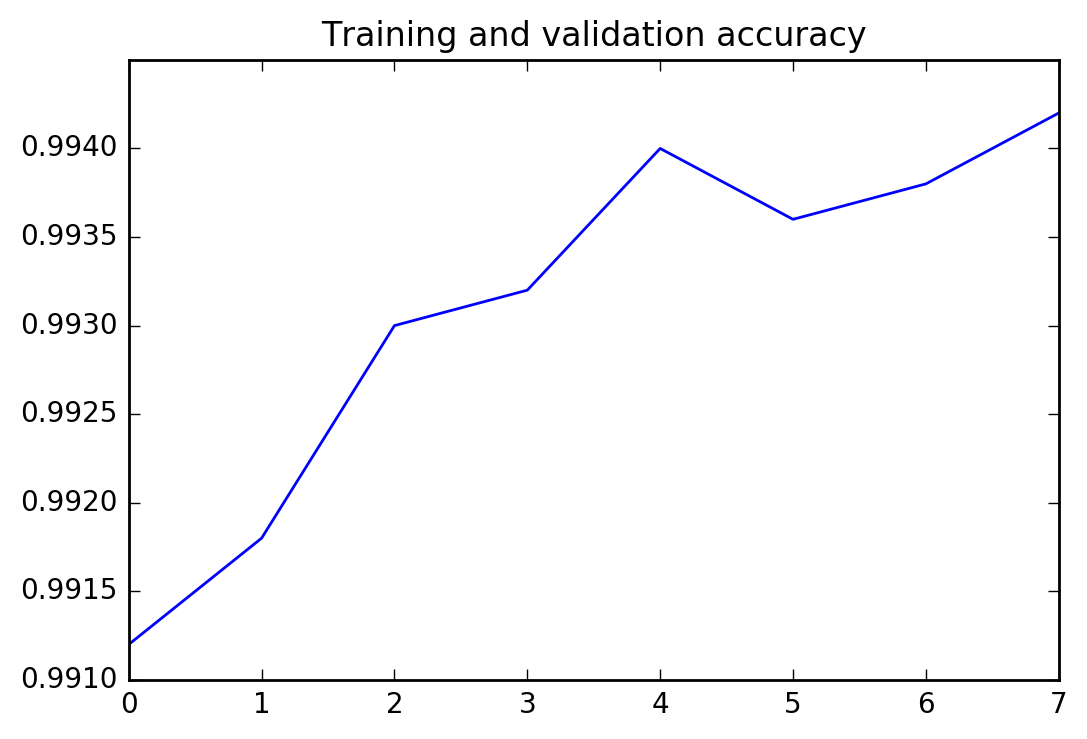

In [46]:
plt.plot(hist.history['val_loss'])
#plt.xlabel('time')
#plt.ylabel('val_loss')
plt.title('Training and validation loss')
plt.show()

plt.plot(hist.history['val_acc'])
#plt.xlabel('times')
#plt.ylabel('val_acc')
plt.title('Training and validation accuracy')
plt.show()

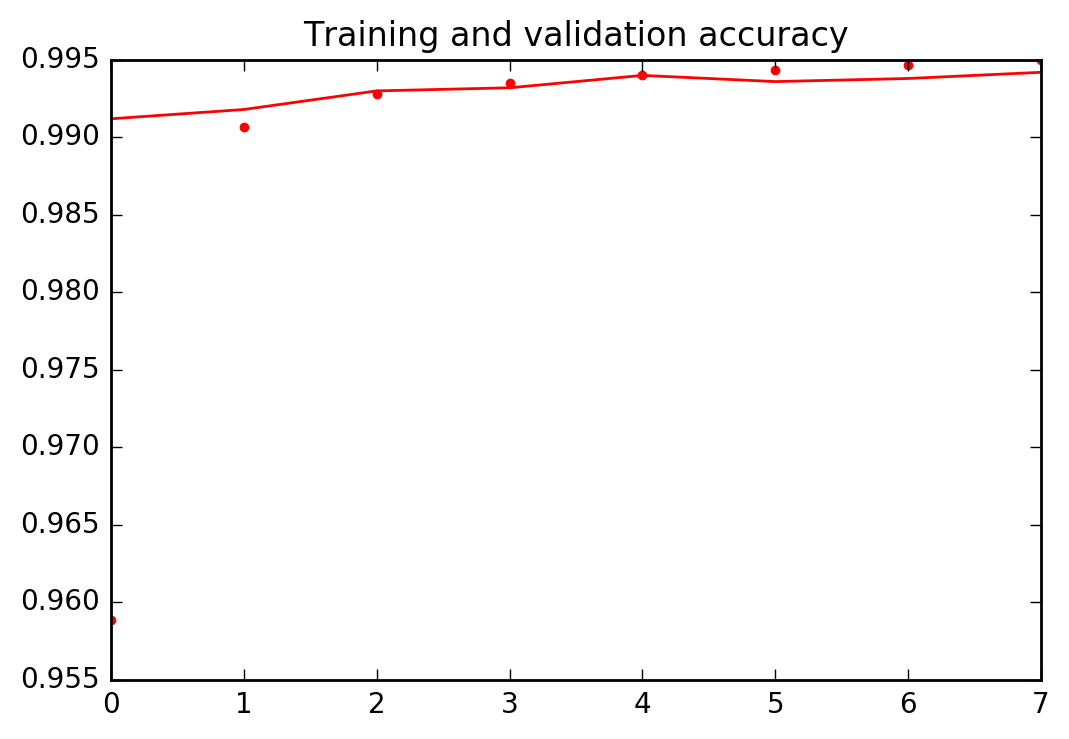

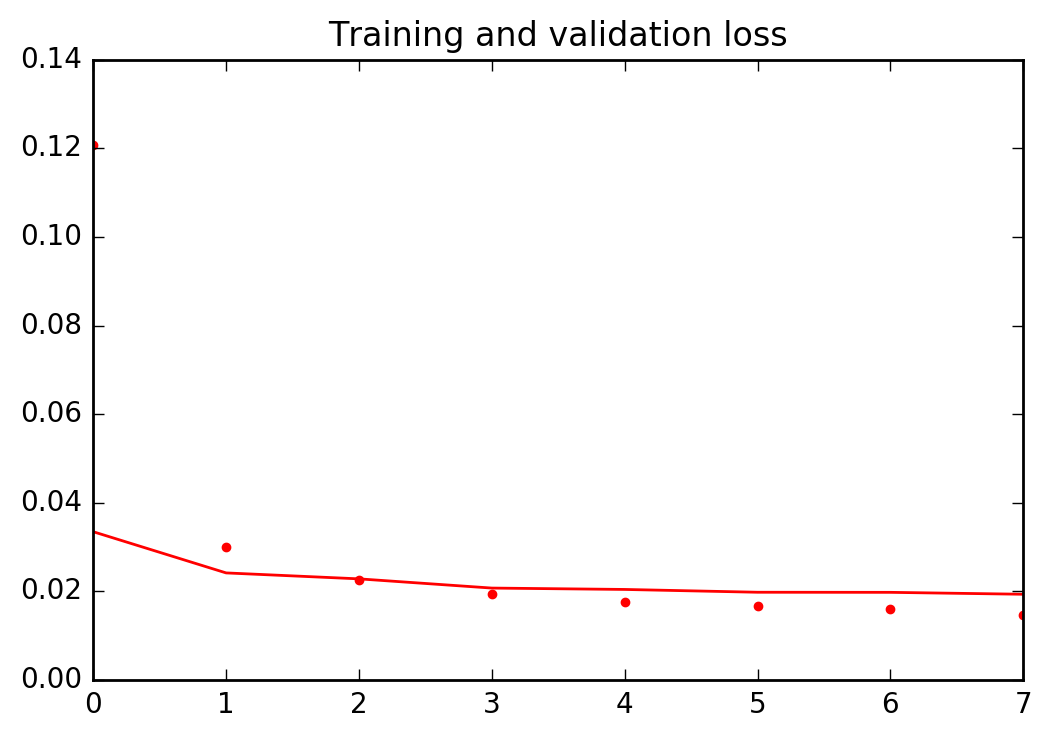

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
# 画图
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']   
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

# 训练的acc_loss图
plot_training(hist)

## 预测测试集

模型训练好以后，我们就可以对测试集进行预测，然后提交到 kaggle 上看看最终成绩了。

In [ ]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

In [21]:
X_test.shape

(12500, 6144)

In [ ]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("img_test", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

预测这里我们用到了一个小技巧，我们将每个预测值限制到了 [0.005, 0.995] 个区间内，这个原因很简单，kaggle 官方的评估标准是 LogLoss，对于预测正确的样本，0.995 和 1 相差无几，但是对于预测错误的样本，0 和 0.005 的差距非常大，是 15 和 2 的差别。参考 LogLoss 如何处理无穷大问题，下面的表达式就是二分类问题的 LogLoss 定义。

$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]$$

还有一个值得一提的地方就是测试集的文件名不是按 1, 2, 3 这样排的，而是按下面的顺序排列的：

In [ ]:
%ls test | head -n 10

因此我们需要对每个文件名进行处理，然后赋值到 df 里，最后导出为 csv 文件。

In [ ]:
from IPython.display import display

data = pd.read_csv("pred.csv")
display(data.head(n=10))

In [ ]:
train_generator.class_indices

In [6]:
gen = ImageDataGenerator()
train_generator = gen.flow_from_directory("img_train", (224, 224), shuffle=False, batch_size=16)

print(train_generator.class_indices)

Found 25000 images belonging to 2 classes.
{'dog': 1, 'cat': 0}


In [7]:
list(train_generator.class_indices.keys())

['dog', 'cat']

In [29]:
pre_x.shape

(1, 128, 128, 3)

In [35]:
model=models.load_model('model.h5')

In [37]:
zip([x.name for x in model.layers], range(len(model.layers)))

In [39]:
model.inputs

[<tf.Tensor 'input_1_13:0' shape=(?, 6144) dtype=float32>]

In [42]:
model.outputs

[<tf.Tensor 'Sigmoid_13:0' shape=(?, 1) dtype=float32>]

In [61]:
len(model.layers)

3

In [62]:
# 模型概括
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 6144)          0                                            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 6144)          0           input_1[0][0]                    
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1)             6145        dropout_1[0][0]                  
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
____________________________________________________________________________________________________


In [ ]:
# 模型可视化
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True) # plot my model

['input_1', 'dropout_1', 'dense_1']

In [68]:
model2 = Model(model.input, [model.layers[2].output, model.output])
#model2 = Model(input=model.input, output=model.get_layer(dense_1).output)

ValueError: Error when checking : expected input_1 to have 2 dimensions, but got array with shape (1, 224, 224, 3)

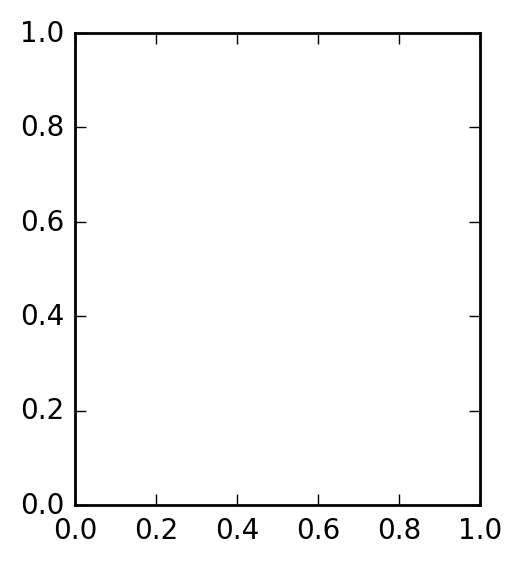

In [70]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 14))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('test/%d.jpg' % random.randint(1, 12500))
    img = cv2.resize(img, (224, 224))
    x = img.copy()
    x.astype(np.float32)
    #print(np.expand_dims(x, axis=0))
    out, prediction = model2.predict(np.expand_dims(x, axis=0))
    #out, prediction = model2.predict(x)

    prediction = prediction[0]
    out = out[0]

    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))

    cam = (prediction - 0.5) * np.matmul(out, weights)
    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8

    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out[:,:,::-1])